# GARCH Analysis

In [41]:
# Imports and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.stats.diagnostic import acorr_ljungbox 
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error



sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

train_file = "train_data.csv"
test_file = "test_data.csv"

try:
    train_df = pd.read_csv(train_file, parse_dates=['Date'])
    train_df.sort_values("Date", inplace=True)
    train_df.set_index("Date", inplace=True)
    print("Training Data:")
    display(train_df.head())
except FileNotFoundError:
    print(f"File {train_file} not found. Please ensure it is in the working directory.")

try:
    test_df = pd.read_csv(test_file, parse_dates=['Date'])
    test_df.sort_values("Date", inplace=True)
    test_df.set_index("Date", inplace=True)
    print("Testing Data:")
    display(test_df.head())
except FileNotFoundError:
    print(f"File {test_file} not found. Please ensure it is in the working directory.")

Training Data:


,Close,Open,High,Low,Log_Returns
Date,,,,,
2020-03-09,2746.56,2863.89,2863.89,2734.43,-0.079010
2020-03-10,2882.23,2813.48,2882.59,2734.00,0.048215
2020-03-11,2741.38,2825.60,2825.60,2707.22,-0.050103
2020-03-12,2480.64,2630.86,2660.95,2478.86,-0.099945
2020-03-13,2711.02,2569.99,2711.33,2492.37,0.088808


Testing Data:


,Close,Open,High,Low,Log_Returns
Date,,,,,
2025-02-05,6061.48,6020.45,6062.86,6007.06,0.003901
2025-02-06,6083.57,6072.22,6084.03,6046.83,0.003638
2025-02-07,6025.99,6083.13,6101.28,6019.96,-0.009510
2025-02-10,6066.44,6046.40,6073.38,6044.84,0.006690
2025-02-11,6068.50,6049.32,6076.28,6042.34,0.000340


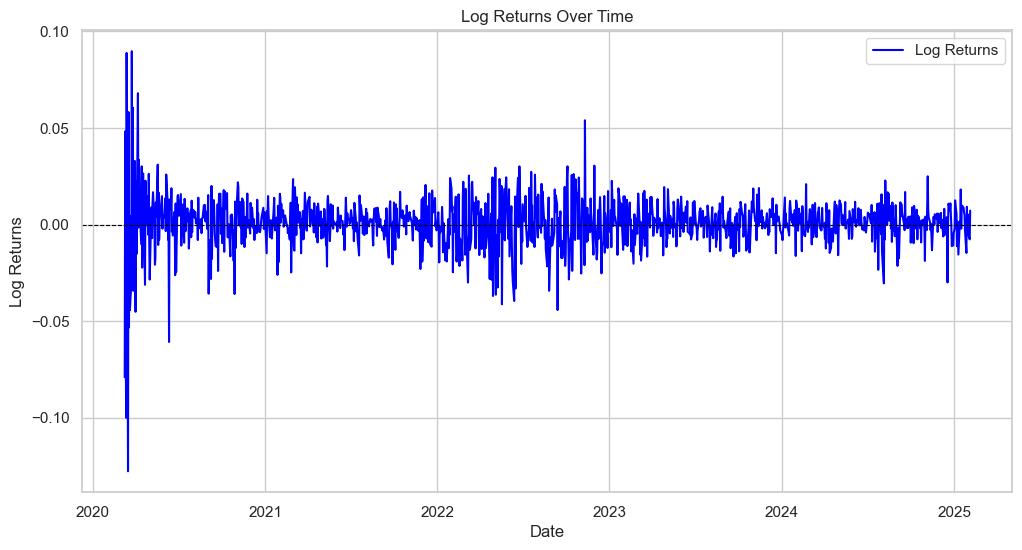

In [33]:
# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Log_Returns'], label='Log Returns', color='blue')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Log Returns Over Time')
plt.legend()
plt.show()

In [34]:
# ADF test

adf_result = adfuller(train_df['Log_Returns']) 
print("Augmented Dickey–Fuller Test on Log_Returns:") 
print(f"Test Statistic: {adf_result[0]:.4f}") 
print(f"P-value: {adf_result[1]:.4f}") 
print("Critical Values:") 
for key, value in adf_result[4].items(): 
  print(f" {key}: {value:.4f}")


# Arch-LM test

lm_test = het_arch(train_df['Log_Returns'], nlags=10) 
print("\nARCH-LM Test on Log_Returns:") 
print(f"LM Statistic: {lm_test[0]:.4f}") 
print(f"LM Test p-value: {lm_test[1]:.4f}") 
print(f"F-statistic: {lm_test[2]:.4f}") 
print(f"F-test p-value: {lm_test[3]:.4f}")


Augmented Dickey–Fuller Test on Log_Returns:
Test Statistic: -13.2921
P-value: 0.0000
Critical Values:
 1%: -3.4357
 5%: -2.8639
 10%: -2.5680

ARCH-LM Test on Log_Returns:
LM Statistic: 556.9731
LM Test p-value: 0.0000
F-statistic: 101.2183
F-test p-value: 0.0000


For the ADF test, a low p-value (e.g., <0.05) indicates rejection of the null hypothesis of a unit root, suggesting that the log returns are stationary.

For the ARCH-LM test, a high p-value (e.g., >0.05) supports the null hypothesis of no ARCH effects, whereas a low p-value may indicate remaining ARCH effects in the series.

### Fitter modeller vha Grid Search

In [35]:
results = []
orders = [(1, 1), (1, 2), (2, 1)]
distributions = ['normal', 't', 'skewt']

train_data = train_df["Log_Returns"]

# Loop over each candidate configuration
for p, q in orders:
    for dist in distributions:
        try:
            model = arch_model(100 * train_data, vol='GARCH', p=p, q=q, dist=dist, rescale=False)
            res = model.fit(disp='off')
            results.append({
                'order': f"GARCH({p},{q})",
                'distribution': dist,
                'AIC': res.aic,
                'BIC': res.bic,
                'LogLikelihood': res.loglikelihood
            })
            print(f"Fitted GARCH({p},{q}) with {dist} distribution: AIC={res.aic:.2f}, BIC={res.bic:.2f}")
        except Exception as e:
            print(f"Model GARCH({p},{q}) with {dist} failed: {e}")

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)
results_df

Fitted GARCH(1,1) with normal distribution: AIC=3570.17, BIC=3590.65
Fitted GARCH(1,1) with t distribution: AIC=3529.84, BIC=3555.44
Fitted GARCH(1,1) with skewt distribution: AIC=3517.98, BIC=3548.69
Fitted GARCH(1,2) with normal distribution: AIC=3572.17, BIC=3597.77
Fitted GARCH(1,2) with t distribution: AIC=3531.84, BIC=3562.56
Fitted GARCH(1,2) with skewt distribution: AIC=3519.98, BIC=3555.81
Fitted GARCH(2,1) with normal distribution: AIC=3571.27, BIC=3596.86
Fitted GARCH(2,1) with t distribution: AIC=3528.76, BIC=3559.48
Fitted GARCH(2,1) with skewt distribution: AIC=3517.41, BIC=3553.24


,order,distribution,AIC,BIC,LogLikelihood
0,"GARCH(1,1)",normal,3570.174294,3590.649599,-1781.087147
1,"GARCH(1,1)",t,3529.842544,3555.436675,-1759.921272
2,"GARCH(1,1)",skewt,3517.976212,3548.689169,-1752.988106
3,"GARCH(1,2)",normal,3572.174294,3597.768425,-1781.087147
4,"GARCH(1,2)",t,3531.842544,3562.555501,-1759.921272
5,"GARCH(1,2)",skewt,3519.976212,3555.807996,-1752.988106
6,"GARCH(2,1)",normal,3571.265866,3596.859997,-1780.632933
7,"GARCH(2,1)",t,3528.764594,3559.477551,-1758.382297
8,"GARCH(2,1)",skewt,3517.405297,3553.237081,-1751.702648


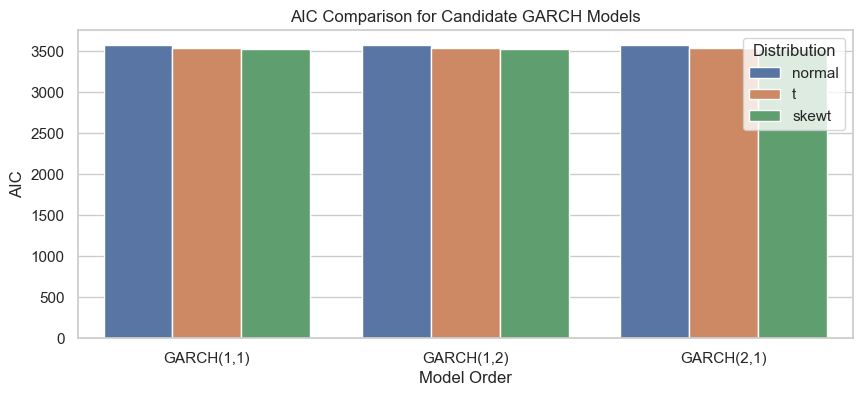

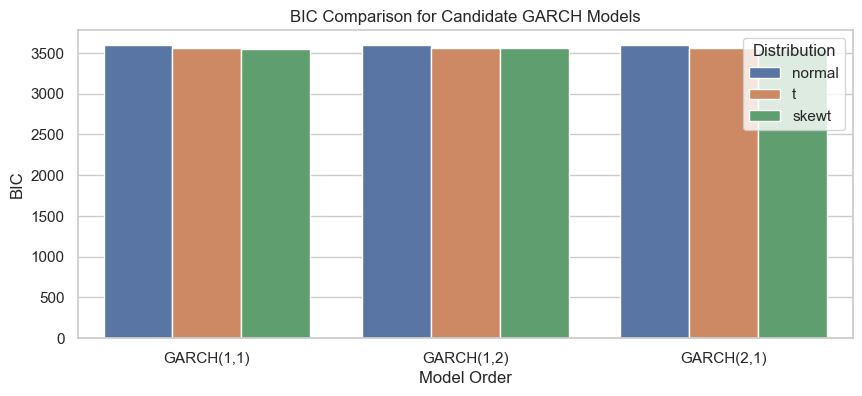

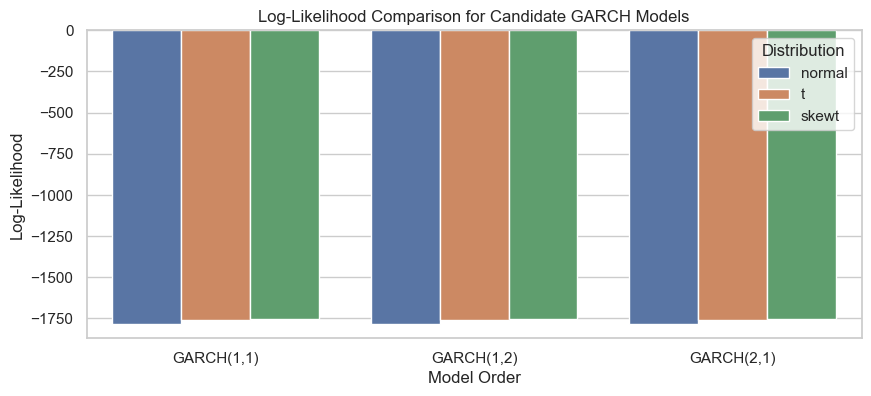

In [13]:
# Plot AIC, BIC and log-likelihood 

plt.figure()
sns.barplot(x="order", y="AIC", hue="distribution", data=results_df)
plt.title("AIC Comparison for Candidate GARCH Models")
plt.ylabel("AIC")
plt.xlabel("Model Order")
plt.legend(title="Distribution")
plt.show()

plt.figure()
sns.barplot(x="order", y="BIC", hue="distribution", data=results_df)
plt.title("BIC Comparison for Candidate GARCH Models")
plt.ylabel("BIC")
plt.xlabel("Model Order")
plt.legend(title="Distribution")
plt.show()

plt.figure()
sns.barplot(x="order", y="LogLikelihood", hue="distribution", data=results_df)
plt.title("Log-Likelihood Comparison for Candidate GARCH Models")
plt.ylabel("Log-Likelihood")
plt.xlabel("Model Order")
plt.legend(title="Distribution")
plt.show()

Modeller er ganske like. Bør teste residuals for å sjekke hvilken av Garch (1,1) modellene som er best

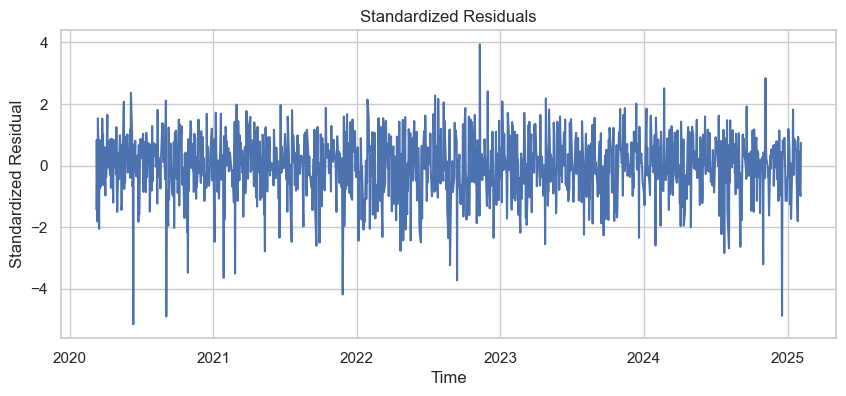

<Figure size 1000x400 with 0 Axes>

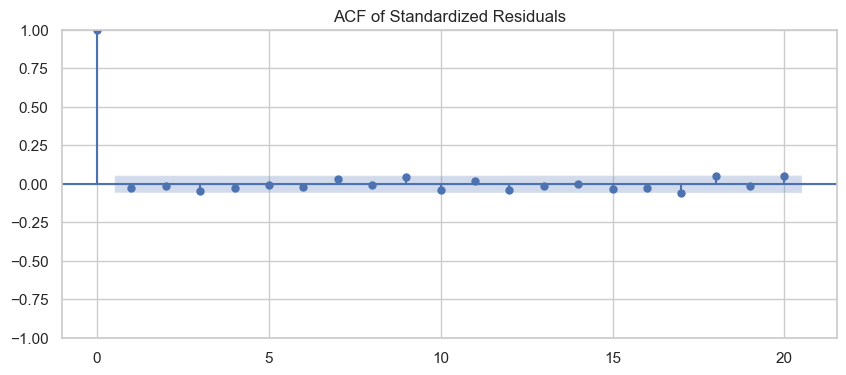

<Figure size 1000x400 with 0 Axes>

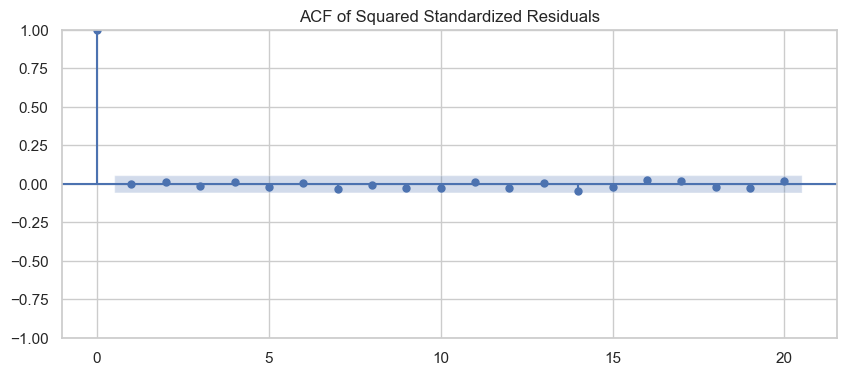

<Figure size 600x600 with 0 Axes>

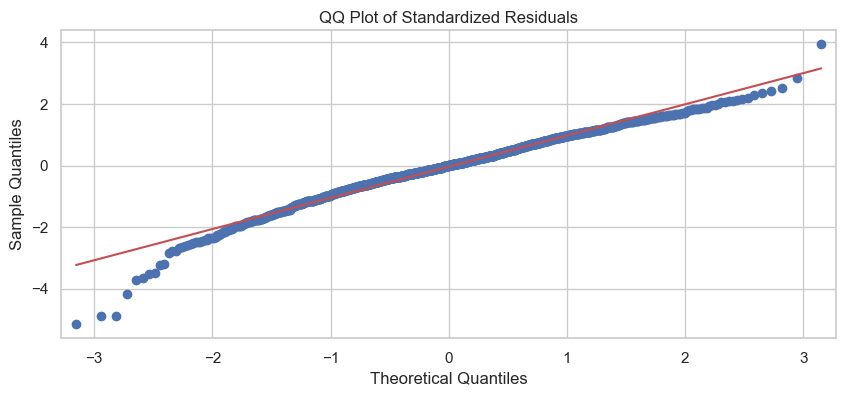

Ljung-Box test on squared standardized residuals (lag 10):
    lb_stat  lb_pvalue
10  4.41243    0.92683


In [ ]:
std_resid = res.std_resid

plt.figure(figsize=(10, 4)) 
plt.plot(std_resid) 
plt.title("Standardized Residuals") 
plt.xlabel("Time") 
plt.ylabel("Standardized Residual") 
plt.show()

plt.figure(figsize=(10, 4)) 
plot_acf(std_resid, lags=20, alpha=0.05) 
plt.title("ACF of Standardized Residuals") 
plt.show()

plt.figure(figsize=(10, 4)) 
plot_acf(std_resid**2, lags=20, alpha=0.05) 
plt.title("ACF of Squared Standardized Residuals") 
plt.show()

plt.figure(figsize=(6, 6)) 
sm.qqplot(std_resid, line='s') 
plt.title("QQ Plot of Standardized Residuals") 
plt.show()

lb_test = acorr_ljungbox(std_resid**2, lags=[10], return_df=True) 
print("Ljung-Box test on squared standardized residuals (lag 10):") 
print(lb_test)

A high p-value (above 0.05) for the Ljung–Box test supports the null of no serial correlation in the squared residuals, suggesting that the model has adequately captured volatility clustering. Feel free to adjust lags or model parameters as needed for your data and analysis.

Basert på disse resultatene velger vi: GARCH(1,1) with normal distribution
Lowest AIC and BIC

Første iterasjon av kode: Ikke så viktig

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                       Log_Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -1752.99
Distribution:      Standardized Skew Student's t   AIC:                           3517.98
Method:                       Maximum Likelihood   BIC:                           3548.69
                                                   No. Observations:                 1235
Date:                           Tue, Mar 25 2025   Df Residuals:                     1234
Time:                                   12:05:27   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Date
2025-02-05    0.846747
2025-02-06    0.852320
2025-02-07    0.857709
2025-02-10    0.862922
2025-02-11    0.867967
2025-02-12    0.872850
2025-02-13    0.877576
2025-02-14    0.882153
2025-02-18    0.886585
2025-02-19    0.890879
2025-02-20    0.895038
2025-02-21    0.899068
2025-02-24    0.902974
2025-02-25    0.906760
2025-02-26    0.910430
2025-02-27    0.913988
2025-02-28    0.917438
2025-03-03    0.920784
2025-03-04    0.924030
2025-03-05    0.927178
dtype: float64

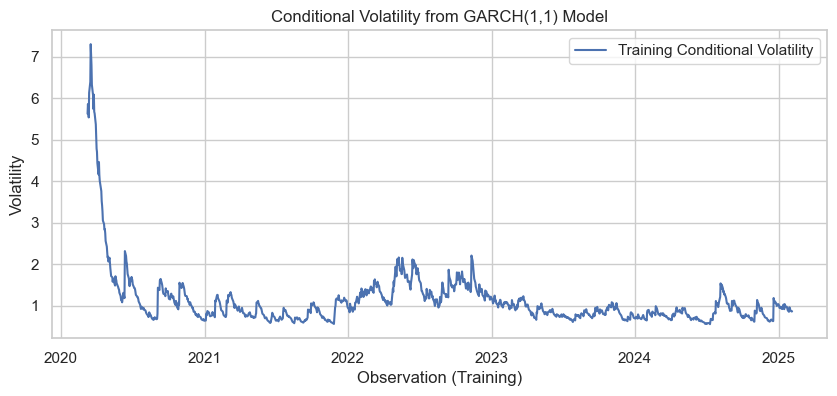

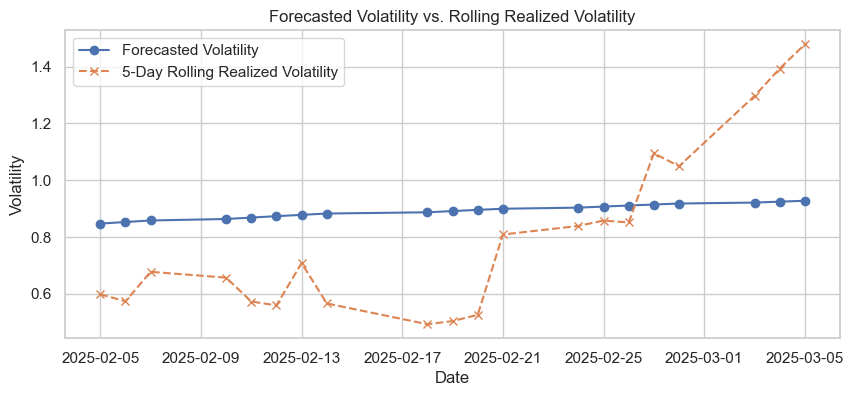

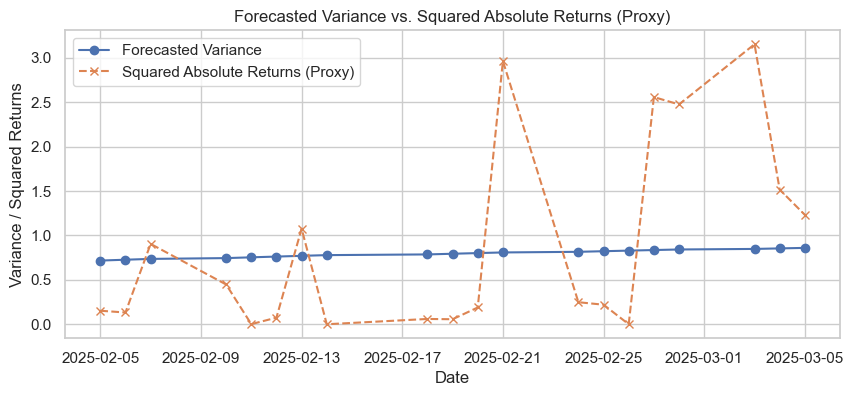

Volatility Forecast Evaluation (Rolling Realized Volatility):
 MSE:   0.0853
 RMSE:  0.2921
 MAE:   0.2568
 QLIKE: 0.6681

Variance Forecast Evaluation (Squared Absolute Returns Proxy):
 MSE:   1.0749
 RMSE:  1.0368
 MAE:   0.8534
 QLIKE: 0.8312


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# -------------------------------
# 1. Fit the GARCH(1,1) Model on Training Data
# -------------------------------
garch_model = arch_model(100 * train_df["Log_Returns"], vol='GARCH', p=1, q=1, dist='skewt', rescale=False)
garch_result = garch_model.fit(disp='off')
print(garch_result.summary())

# -------------------------------
# 2. Forecast Volatility Over the Test Period
# -------------------------------
forecast_horizon = len(test_df)
forecasts = garch_result.forecast(horizon=forecast_horizon, reindex=False)
forecasted_variance = forecasts.variance.iloc[-1]  # forecasted variances (default index)
forecasted_volatility = np.sqrt(forecasted_variance)

# Create forecasted variance series with test_df index
forecast_var_series = pd.Series(forecasted_variance.values, index=test_df.index)
# Also create forecasted volatility series with test_df index
forecast_vol_series = pd.Series(forecasted_volatility.values, index=test_df.index)

print("Forecasted Volatility:")
display(forecast_vol_series)

# -------------------------------
# 3. Plot In-Sample Conditional Volatility
# -------------------------------
plt.figure()
plt.plot(garch_result.conditional_volatility, label='Training Conditional Volatility')
plt.title("Conditional Volatility from GARCH(1,1) Model")
plt.xlabel("Observation (Training)")
plt.ylabel("Volatility")
plt.legend()
plt.show()

# -------------------------------
# 4. Compute Rolling Realized Volatility (Using Tail of Training Data)
# -------------------------------
window = 5  # rolling window size
# Combine last (window-1) observations from training with test data
combined_returns = pd.concat([train_df["Log_Returns"].tail(window-1), test_df["Log_Returns"]])
combined_sq = (100 * combined_returns)**2  # squared returns (volatility proxy)
combined_roll_mean = combined_sq.rolling(window=window).mean()
# Extract the test period part
realized_var_roll = combined_roll_mean.loc[test_df.index]
realized_vol_roll = np.sqrt(realized_var_roll)

# Also compute the squared absolute returns proxy directly from test data
proxy_var = (100 * np.abs(test_df["Log_Returns"]))**2

# -------------------------------
# 5. Plot Forecasted Volatility vs. Realized Measures
# -------------------------------
plt.figure()
plt.plot(test_df.index, forecast_vol_series, marker='o', linestyle='-', label='Forecasted Volatility')
plt.plot(test_df.index, realized_vol_roll, marker='x', linestyle='--', label=f'{window}-Day Rolling Realized Volatility')
plt.title("Forecasted Volatility vs. Rolling Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

plt.figure()
plt.plot(test_df.index, forecast_var_series, marker='o', linestyle='-', label='Forecasted Variance')
plt.plot(test_df.index, proxy_var, marker='x', linestyle='--', label='Squared Absolute Returns (Proxy)')
plt.title("Forecasted Variance vs. Squared Absolute Returns (Proxy)")
plt.xlabel("Date")
plt.ylabel("Variance / Squared Returns")
plt.legend()
plt.show()

# -------------------------------
# 6. Evaluate Forecast Accuracy: MSE, RMSE, MAE, QLIKE
# -------------------------------
# Use dates where rolling realized volatility is available (dropping NaNs)
common_index = realized_vol_roll.dropna().index.intersection(forecast_vol_series.index)
# For volatility (standard deviation)
realized_vol = realized_vol_roll.loc[common_index]
predicted_vol = forecast_vol_series.loc[common_index]

mse_vol = mean_squared_error(realized_vol, predicted_vol)
rmse_vol = np.sqrt(mse_vol)
mae_vol = mean_absolute_error(realized_vol, predicted_vol)
# QLIKE loss for variance forecasts (using realized variance proxy)
realized_var = realized_vol**2  # alternatively, use realized_var_roll.loc[common_index]
predicted_var = forecast_var_series.loc[common_index]
qlike_vol = np.mean(np.log(predicted_var) + (realized_var / predicted_var))

print("Volatility Forecast Evaluation (Rolling Realized Volatility):")
print(f" MSE:   {mse_vol:.4f}")
print(f" RMSE:  {rmse_vol:.4f}")
print(f" MAE:   {mae_vol:.4f}")
print(f" QLIKE: {qlike_vol:.4f}")

# Also evaluate against the squared absolute returns proxy
common_index_proxy = proxy_var.dropna().index.intersection(forecast_var_series.index)
mse_proxy = mean_squared_error(proxy_var.loc[common_index_proxy], forecast_var_series.loc[common_index_proxy])
rmse_proxy = np.sqrt(mse_proxy)
mae_proxy = mean_absolute_error(proxy_var.loc[common_index_proxy], forecast_var_series.loc[common_index_proxy])
qlike_proxy = np.mean(np.log(forecast_var_series.loc[common_index_proxy]) +
                        (proxy_var.loc[common_index_proxy] / forecast_var_series.loc[common_index_proxy]))

print("\nVariance Forecast Evaluation (Squared Absolute Returns Proxy):")
print(f" MSE:   {mse_proxy:.4f}")
print(f" RMSE:  {rmse_proxy:.4f}")
print(f" MAE:   {mae_proxy:.4f}")
print(f" QLIKE: {qlike_proxy:.4f}")
